In [1]:
import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import pyro
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform
from pyro.distributions.util import scalar_like
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro.util import ignore_experimental_warning

In [3]:
import mysbi.models
from mysbi.nde import NeuralRatioEstimator
from mysbi.sequential import Sequential

In [4]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [5]:
class MultivariateUniform():
    def __init__(self, low, high):
        self.dist = torch.distributions.Uniform(low, high)
        self.mean = self.dist.mean
        
    def log_prob(self, x):
        return self.dist.log_prob(x).sum(-1)
        
    def sample(self, it):
        return self.dist.sample(it)
    
        

In [6]:
num_dim = 3
observation = torch.zeros(1, num_dim)

def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1


In [7]:
def simulation_wrapper(params, sims_per_model=1):
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    return simulator(params)

In [8]:
layers = [['Linear', 2*num_dim, 10], ['ReLU'], ['Linear', 10, 1]]
model = mysbi.models.Classifier(layers=layers)
optimizer = torch.optim.AdamW(model.parameters())

In [9]:
priors = MultivariateUniform(low=-2*torch.ones(num_dim), high=2*torch.ones(num_dim))

nre = NeuralRatioEstimator(model)
snre = Sequential(priors=priors, obs_data=observation, model=nre, optimizer=optimizer, 
                  simulator=simulation_wrapper, 
                  num_initial_samples=300,
                  num_samples_per_round=1000)

In [10]:
snre.run()

Warmup:   0%|          | 0/300 [00:00, ?it/s]

Training on 255 samples. Validating on 45 samples.
Early stopped after 11 epochs
Round 1 complete. Time elapsed: 0m 0s. Total time elapsed: 0m 0s.


Validation Loss: 1.919:   2%|▏         | 3/200 [00:00<00:09, 20.79it/s]

Training on 1,105 samples. Validating on 195 samples.


Warmup:   3%|▎         | 9/300 [00:00, 89.49it/s, step size=1.46e-01, acc. prob=0.676]

Early stopped after 131 epochs
Round 2 complete. Time elapsed: 0m 8s. Total time elapsed: 0m 8s.


Validation Loss: 0.532:   1%|          | 2/200 [00:00<00:16, 12.09it/s]

Training on 1,955 samples. Validating on 345 samples.


Warmup:   4%|▎         | 11/300 [00:00, 104.48it/s, step size=3.98e-01, acc. prob=0.727]

Early stopped after 27 epochs
Round 3 complete. Time elapsed: 0m 5s. Total time elapsed: 0m 13s.


Validation Loss: 0.549:   0%|          | 1/200 [00:00<00:24,  8.24it/s]

Training on 2,805 samples. Validating on 495 samples.


Warmup:   5%|▌         | 15/300 [00:00, 132.75it/s, step size=5.77e-02, acc. prob=0.704]

Early stopped after 36 epochs
Round 4 complete. Time elapsed: 0m 7s. Total time elapsed: 0m 19s.


Validation Loss: 0.585:   0%|          | 1/200 [00:00<00:30,  6.54it/s]

Training on 3,655 samples. Validating on 645 samples.


Warmup:   6%|▌         | 18/300 [00:00, 178.51it/s, step size=1.57e-01, acc. prob=0.762]

Early stopped after 27 epochs
Round 5 complete. Time elapsed: 0m 6s. Total time elapsed: 0m 26s.


  0%|          | 0/200 [00:00<?, ?it/s]

Training on 4,505 samples. Validating on 795 samples.


Warmup:   4%|▍         | 13/300 [00:00, 126.45it/s, step size=1.46e-01, acc. prob=0.713]

Early stopped after 16 epochs
Round 6 complete. Time elapsed: 0m 6s. Total time elapsed: 0m 31s.


  0%|          | 0/200 [00:00<?, ?it/s]

Training on 5,355 samples. Validating on 945 samples.


Warmup:   6%|▌         | 18/300 [00:00, 178.00it/s, step size=4.48e-02, acc. prob=0.714]

Early stopped after 17 epochs
Round 7 complete. Time elapsed: 0m 6s. Total time elapsed: 0m 38s.


  0%|          | 0/200 [00:00<?, ?it/s]

Training on 6,205 samples. Validating on 1,095 samples.


Warmup:   5%|▌         | 15/300 [00:00, 126.17it/s, step size=3.27e-02, acc. prob=0.692]

Early stopped after 16 epochs
Round 8 complete. Time elapsed: 0m 7s. Total time elapsed: 0m 45s.


  0%|          | 0/200 [00:00<?, ?it/s]

Training on 7,055 samples. Validating on 1,245 samples.


Warmup:   6%|▌         | 18/300 [00:00, 177.92it/s, step size=4.75e-01, acc. prob=0.757]

Early stopped after 11 epochs
Round 9 complete. Time elapsed: 0m 5s. Total time elapsed: 0m 50s.


  0%|          | 0/200 [00:00<?, ?it/s]

Training on 7,905 samples. Validating on 1,395 samples.


Validation Loss: 1.025:   6%|▋         | 13/200 [00:04<01:07,  2.77it/s]

Early stopped after 13 epochs
Round 10 complete. Time elapsed: 0m 7s. Total time elapsed: 0m 57s.


In [11]:
import corner

In [20]:
posterior_samples = snre.hmc(num_samples=30000, walker_steps=5000, burn_in=200)

Sample: 100%|██████████| 5200/5200 [00:29, 177.36it/s, step size=5.52e-01, acc. prob=0.795]


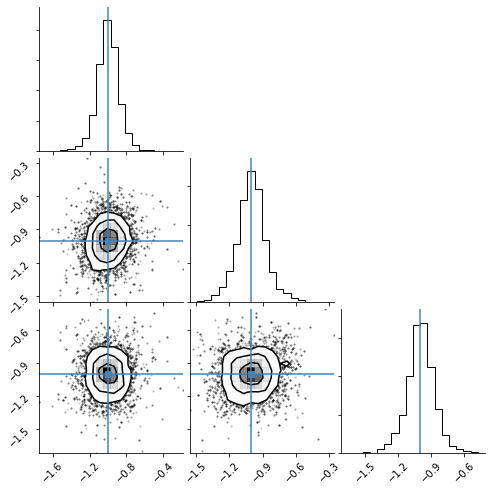

In [21]:
corner.corner(posterior_samples, 
#               range=[(-2, 2) for i in range(num_dim)], 
                    truths=-torch.ones(num_dim));